In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
classes = ['Dandelion','Snowdrop','lily Valley','bluebell','Crocus','Iris','Tigerlily','Tulip','Fritillary','SunFlower','Daisy','Colts Fool','Dandelion', 'Cowslip','Buttercup','Windflower','Pansy']

In [ ]:
path = '/content/drive/MyDrive/CS231.M21.KHCL/Baitap/Dataset/17flowers/jpg/'

In [ ]:
def TinhHist(pathfile):
  img = cv2.imread(pathfile,0)
  hist = cv2.calcHist([img],[0],None,[256],[0,256])
  size = img.shape[0]*img.shape[1]
  hist = hist/size
  return hist

In [ ]:
from skimage import feature
def compute_hog_train(train_images):
  train_features =[]
  for img in train_images: 
    img =cv2.resize(img, (128, 256))
    (hog, hog_image) = feature.hog(img, orientations=9, 
                    pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                    block_norm='L2-Hys', visualize=True, transform_sqrt=True)


    train_features.append(hog)
  return np.array(train_features)


In [ ]:
#Đọc data từ cái dir
#Option 0 là Tính theo Hist option 1 là tính theo HOG 
from sklearn.model_selection import train_test_split
def read_data(path_file,option):
  filenames = os.listdir(path_file)
  categories = []
  Hist_img = []
  train_images = []
  #filenames = filenames.sort()
  for filename in sorted(filenames):
    category = filename.split('image_')[1]
    category = category.split('.')[0]
    category = int(category)
    if option == 0:
      Hist_img.append(TinhHist(path_file+filename).reshape(-1))
    elif option ==1:
      img = cv2.imread(path_file+filename,0)
      train_images.append(img)
    else :
      raise ValueError('Option is illegal')   
    categories.append((category-1)//80)
    #if category < 81:
        #categories.append(0) #Đây là hoa Dandelion
    #else:
        #categories.append(1) #Đây là hoa Snowdrop
  #df = pd.DataFrame({
  #  'filename': filenames,
  #  'category': categories
  #})
  #print(df)
  if option ==0:
    X = np.array(Hist_img)
  elif option == 1:
    X = compute_hog_train(train_images)  
  y = np.array(categories) 
  
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)
  
  df_train_filename, df_test_filename, df_train_category, df_test_category = train_test_split( filenames, categories, test_size=0.2)


  df_train = pd.DataFrame({
    'filename': df_train_filename,
    'category': df_train_category
  })
  df_test = pd.DataFrame({
    'filename': df_test_filename,
    'category': df_test_category
  })
  return df_train,df_test, X_train, X_test, y_train, y_test    

In [ ]:
#Hàm dự đoán nhãn
#Cái path_file_train_images tùy vào option
def predict_label(path_file_train_images,model,option):
  if option == 0:
    hist = TinhHist(path_file_train_images)
    features = hist.reshape(1,-1)
    label = model.predict(features)
  elif option == 1:
    HOG = compute_hog_train(path_file_train_images)
    label = model.predict(HOG)
  else :
    raise ValueError('Option is illegal')
  return label

In [ ]:
#Hàm thể hiện hình ảnh cho đẹp
def display_image(path , df,option= None,model = None):
  if option == 1 :
    train_images=[]
    for img_name in df.filename:
      img = cv2.imread(path+img_name,0)
      train_images.append(img)
  if option != 1 and option != 0 and option!= None :
    raise ValueError('Option is illegal')
  fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

  for i, ax in enumerate(axes.flat):
      path_file = path+df.filename[i]
      ax.imshow(plt.imread(path_file))
      if model is None:
        ax.set_title(classes[df.category[i]], fontsize = 12)        
      else:
        if option == 0:
          label = predict_label(path_file,model,option)
          ax.set_title(f"True: {classes[df.category[i]]}\nPredicted: {classes[int(label)]}", fontsize = 12)
        elif option == 1 :
          label = predict_label(train_images,model,option)
          #print(label[i])
          ax.set_title(f"True: {classes[df.category[i]]}\nPredicted: {classes[int(label[i])]}", fontsize = 12)  
  plt.tight_layout(pad=0.5)
  plt.show()

#Sử dụng Kmean

##Tính theo Histogram

In [ ]:
df_train,df_test,X_train, X_test, y_train, y_test = read_data(path,option = 0)

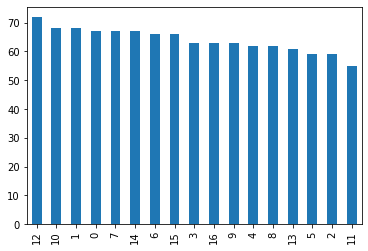

In [ ]:
df_train['category'].value_counts().plot.bar()

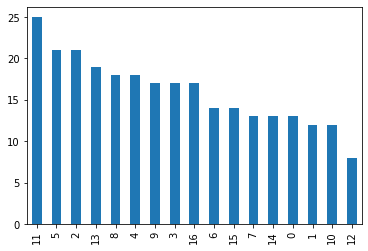

In [ ]:
df_test['category'].value_counts().plot.bar()

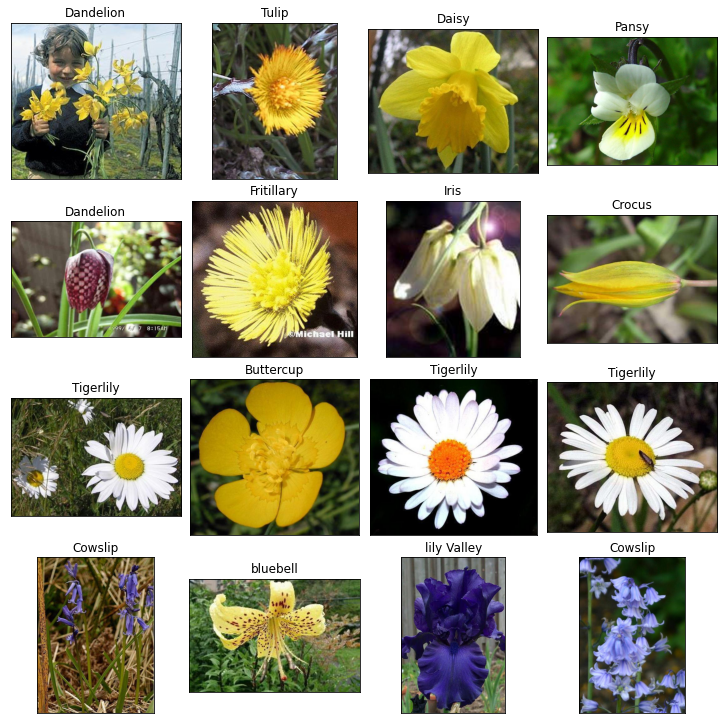

In [ ]:
#Hiển thị 1 số ảnh train
display_image(path,df_train)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [ ]:
k_neighbor = list(range(1,y_train.shape[0]+1))
acc = []
knn_model = KNN(n_neighbors=1,p = 2)
knn_model.fit(X_train, y_train)
acc_check=knn_model.score(X_test, y_test)
for i in  k_neighbor:
  knn = KNN(n_neighbors=i,p = 2)
  knn.fit(X_train, y_train)
  acc.append(knn.score(X_test, y_test))
  if acc[-1]>acc_check:
    knn_model = knn
    acc_check = acc[-1] 

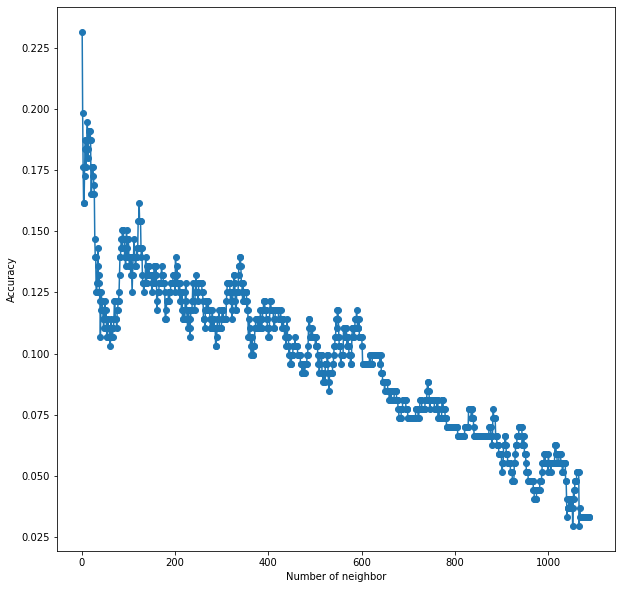

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(k_neighbor, acc, '-o')
plt.xlabel('Number of neighbor')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
print(acc_check)

0.23161764705882354


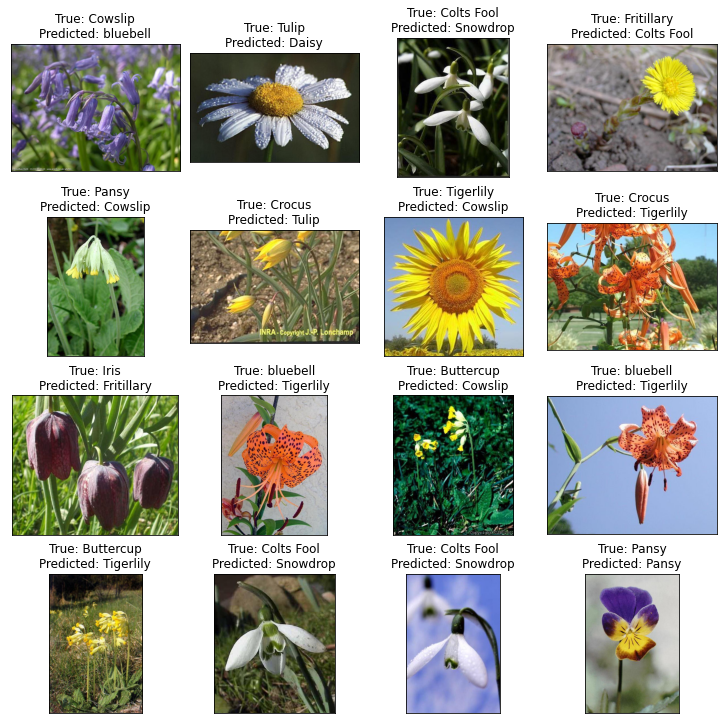

In [ ]:
display_image(path,df_test,0,knn_model)

##Tính theo HOG

In [ ]:
df_train,df_test,X_train, X_test, y_train, y_test = read_data(path,option = 1)

In [ ]:
k_neighbor = list(range(1,y_train.shape[0]+1))
acc = []
knn_model = KNN(n_neighbors=1,p = 2)
knn_model.fit(X_train, y_train)
acc_check=knn_model.score(X_test, y_test)
for i in  k_neighbor:
  knn = KNN(n_neighbors=i,p = 2)
  knn.fit(X_train, y_train)
  acc.append(knn.score(X_test, y_test))
  if acc[-1]>acc_check:
    knn_model = knn
    acc_check = acc[-1] 

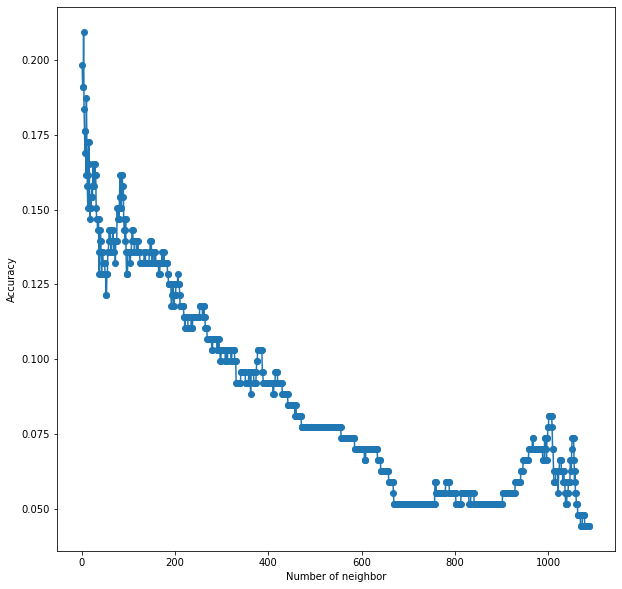

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(k_neighbor, acc, '-o')
plt.xlabel('Number of neighbor')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
print(acc_check)

0.20955882352941177


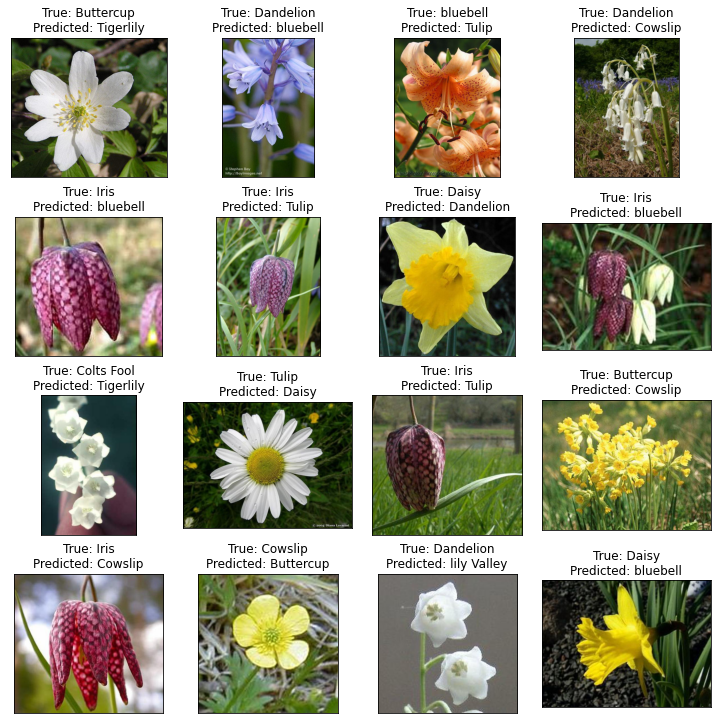

In [ ]:
display_image(path,df_test,1,knn_model)

#Tính theo LinearRegesstion

In [ ]:
from sklearn.linear_model import LinearRegression

##Tính theo Histogram

In [ ]:
df_train,df_test,X_train, X_test, y_train, y_test = read_data(path,option = 0)

In [ ]:
Linear_reg = LinearRegression()
Linear_reg.fit(X_train, y_train)
print('Accuracy:', Linear_reg.score(X_test, y_test))

Accuracy: -11.80753419440703


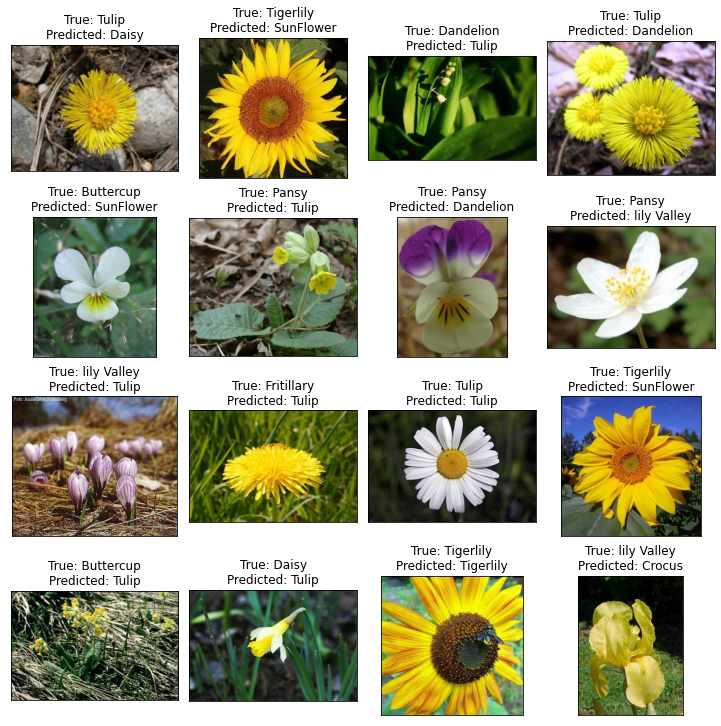

In [ ]:
display_image(path,df_test,0,Linear_reg)

##Tính theo HOG

In [ ]:
df_train,df_test,X_train, X_test, y_train, y_test = read_data(path,option = 1)

In [ ]:
Linear_reg = LinearRegression().fit(X_train, y_train)
print('Accuracy:', Linear_reg.score(X_test, y_test))

Accuracy: 0.8075341944070296


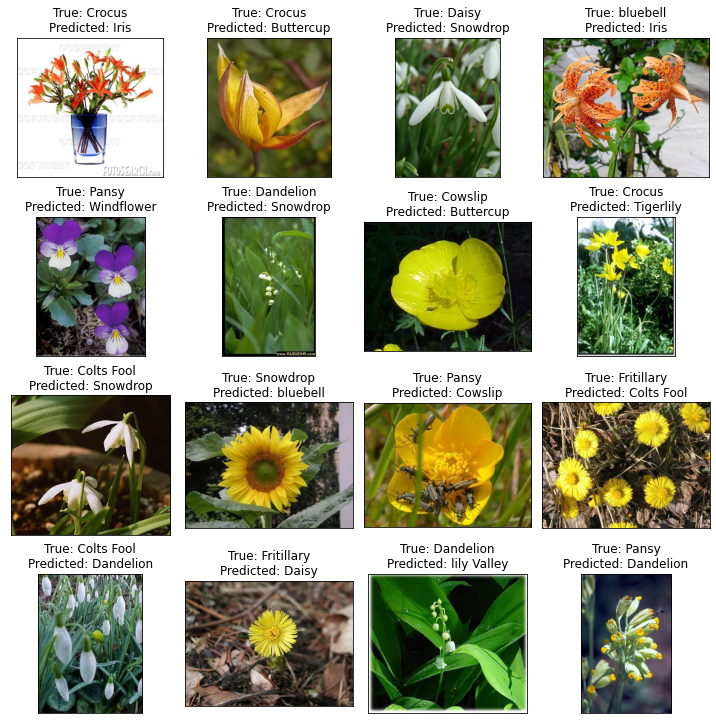

In [ ]:
display_image(path,df_test,1,Linear_reg)